In [1]:
#amulya yakkala 1002114896

!pip install ipympl
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
%matplotlib widget
import numpy as np    
from sklearn import datasets
from sklearn import datasets
from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
from sklearn import preprocessing

def linear_kernel(x1, x2):
    return x1.T @ x2

def polykernel(x1, x2):
    return (np.dot(x1, x2.T) + 1) ** 2

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter

        if self._kernel == 'linear':
            self._k = linear_kernel

        if self._kernel == 'poly':
            self._k = polykernel

        self._c = c

    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0

        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)

        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u

    def predict(self, x):
        """Classifies input samples.

        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L5 = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L5 = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L5 == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L5:
                a2 = L5
            elif a2 >= H:
                a2 = H
        #  the negative case is implemented below
        else:
            L1, H1 = alpha1 + (s * (alpha2 - L5)), alpha1 + (s * (alpha2 - H))
            f1 = (y1 * (e1 + self._b)) - (alpha1 * k11) - (s * alpha2 * k12)
            f2 = (y2 * (e2 + self._b)) - (s * alpha1 * k12) - (alpha2 * k22)
            Lobj = (L1 * f1) + (L5 * f2) + (0.5 * L1 * L1 * k11) + (0.5 * L5 * L5 * k22) + (s * L5 * L1 * k12)
            Hobj = (H1 * f1) + (H * f2) + (0.5 * H1 * H1 * k11) + (0.5 * H * H * k22) + (s * H * H1 * k12)
            if Lobj < Hobj - 1e-3:
              a2 = L
            elif Lobj > Hobj + 1e-3:
              a2 = H
            else:
              a2 = alpha2

        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1d = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2d = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1d + b2d) / 2
        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)

        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # updating the  error cache using new multipliers below
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # picking the first multiplier using heuristic
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                i1 = 0
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1

                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1

                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1

        return 0

    def fit(self, data, targets):
        self._data = data
        self._targets = targets

        self._init_params()

        n_changed = 0
        examine_all = True
        n_iter = 0

        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1

            if examine_all is True:
                # loop over all training examples for changing parameters
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # using for loop for examples where alpha is not 0 and not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)

            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [2]:
# Non-PSD kernel example was shown below for understanding
def non_psd_kernel123():

  X = np.array([[1, 0], 
                [1, 0]])

  Gamma = X.T @ X

  print(Gamma)

  print("The matrix has a 0 eigenvalue so it is not PSD. This  has occured because we have duplicate training examples in the data.")

# Calling  the functions 
non_psd_kernel123()

[[2 0]
 [0 0]]
The matrix has a 0 eigenvalue so it is not PSD. This  has occured because we have duplicate training examples in the data.


# the implementation of negative case of task 1

In [3]:
#initalizng samples 
n_a_samples1 = 50
n_b_samples1 = 50

asamples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples1)
bsamples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples1)
atargets = np.ones(n_a_samples1) * -1  # Samples from class A are assigned a class value of -1.
btargets = np.ones(n_b_samples1)  # Samples from class B are assigned a class value of 1.
#initializing targets
samples12 = np.concatenate((asamples, bsamples))
targets12 = np.concatenate((atargets, btargets))
#printing samples and targets
print(samples12.shape, targets12.shape)

(100, 2) (100,)


In [4]:
models1 = svm(c=5.0)
models1.fit(samples12, targets12)
print(models1._weights)
print(models1._b)

[ 0.98207902 -0.66069307]
-0.038643494110666615


# non linear svm 


In [5]:
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=0)
for i in range(len(y_train)):
  if y_train[i] == 0:
    y_train[i] = -1
for i in range(len(y_test)):
  if y_test[i] == 0:
    y_test[i] = -1
svm_model = svm("poly", c=1)
svm_model.fit(X_train, y_train)
r = []
for i in X_test:
  res = svm_model.predict(i)
  r.append(res)
matches = 0
for i in range(len(r)):
    if r[i] == y_test[i]:
        matches += 1
p = matches/len(y_test)
print("Accuracy = ", p * 100)

Accuracy =  100.0


i have visualised the output by using the diagram below with the help of plot_decision _regions 

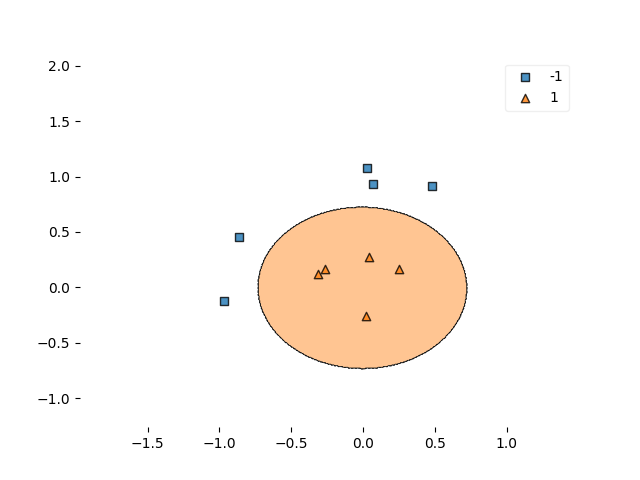

In [6]:

fig = plt.figure()
ax = plot_decision_regions(X_test, np.array(r), svm_model)
fig.add_subplot(ax)
plt.show()

i have compared the implementation above with using sklearn.svm.svc for both of the kernals i.e linear kernal and polykenal

In [7]:
from sklearn.svm import SVC
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.10)
clf = SVC(kernel = 'linear')
clf.fit(X_train, y_train)
r = clf.predict(X_test)
matches = 0
for i in range(len(r)):
    if r[i] == y_test[i]:
        matches += 1
p = matches/len(y_test)
print("Accuracy = ", p * 100)

clf = SVC(kernel = 'poly', degree = 2)
clf.fit(X_train, y_train)
r = clf.predict(X_test)
matches = 0
for i in range(len(r)):
    if r[i] == y_test[i]:
        matches += 1
p = matches/len(y_test)
print("Accuracy = ", p * 100)

Accuracy =  50.0
Accuracy =  100.0


In [8]:
#from above e can see that i got the accuracy of 50.0 for linear kernal 
#and 100.0 for polykernal 

In [9]:
import copy
class MultiSVM:
#defing the init method 
  def __init__(self, num_classes, mod):
    self.num_classes = num_classes
    self.mod = mod
    self.results = [[],[],[]]
#defining the train_test method 
  def train_test(self, x, y, x1):
    for i in range(self.num_classes):
        y1 = copy.deepcopy(y)
        for j in range(len(y1)):
            if y1[j] == i:
              y1[j] = 1
            else:
              y1[j] = -1
        model = svm(self.mod, c=1.0)
        model.fit(x, y1)
        for j in range(len(x1)):
            p = model.predict_score(x1[j])
            self.results[i].append(p)
    return self.results

# multi class svm

below is the implementation i did and the accuracu i have got for multi class svm with linear krnal accuracy is 53.3

In [10]:
#loading the data
iris1 = datasets.load_iris()
X = iris1.data
y = iris1.target
#splitting the data into tran and test for preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
m1 = MultiSVM(3, 'linear')
r = m1.train_test(X_train, y_train, X_test)
matches  = 0
for i in range(len(y_test)):
    m112 = [r[0][i], r[1][i], r[2][i]]
    maxis = max(m112)
    ifos = m112.index(maxis)
    if ifos == y_test[i]:
        matches += 1
print(matches/len(y_test) * 100)

76.66666666666667


below is the implementation of multclass svm with polykernal and the accuracy is printed below aftr the succesful implementation of code 

In [11]:
iris1 = datasets.load_iris()
X = iris1.data
y = iris1.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
m1 = MultiSVM(3, 'poly')
r = m1.train_test(X_train, y_train, X_test)
matches  = 0
for i in range(len(y_test)):
    m112 = [r[0][i], r[1][i], r[2][i]]
    maxis = max(m112)
    ifose = m112.index(maxis)
    if ifose == y_test[i]:
        matches += 1
print(matches/len(y_test) * 100)

86.66666666666667


In [12]:
#below is the implementation of my multiclass svm with svc
# below is the accuracy of svc using linear keranal 

In [13]:
from sklearn.svm import SVC
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
mod = SVC(kernel = 'linear')
mod.fit(X_train, y_train)
resul = mod.predict(X_test)
matches = 0
for i in range(len(y_test)):
    if y_test[i] == resul[i]: matches += 1
p = matches/len(y_test)
print(p * 100)

93.33333333333333


In [14]:
# below is accuracy of multi class svm using polykernal accuracy 

In [ ]:
from sklearn.svm import SVC
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
mod = SVC(kernel = 'poly')
mod.fit(X_train, y_train)
resul = mod.predict(X_test)
matches = 0
for i in range(len(y_test)):
    if y_test[i] == resul[i]: matches += 1
p = matches/len(y_test)
print(p * 100)

93.33333333333333


In [ ]:

#here we are  importing crces dta set
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
#creating variables like test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
#printing the test varailes 
print(y_test)

[1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1]


[ 2.10214782 -1.74851066]
1.739227060164454
accuracy 68.0


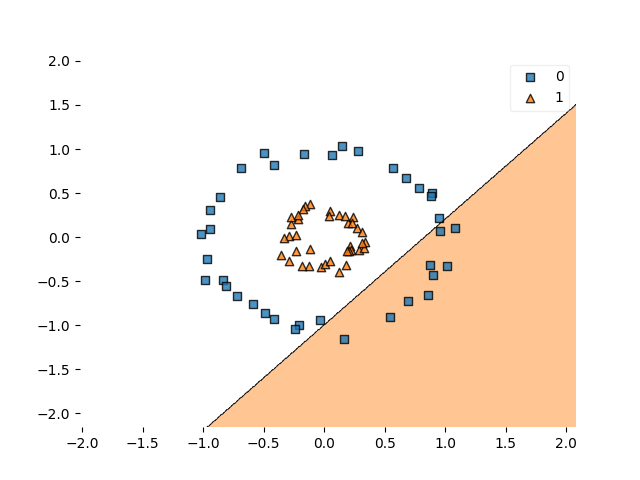

In [ ]:
amumodels12 = svm(c=5.0)    #changed
amumodels12.fit(X_train, y_train)
print(amumodels12._weights)
print(amumodels12._b)
#plotting the figure to check the data regions 
fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, amumodels12)
fig.add_subplot(ax)
#below is the ypredicted value 
y_pred12 = amumodels12.predict(X_test)
# print(y_pred)
for i in range (len(y_pred12)):
    if y_pred12[i] == -1:
        y_pred12[i] = 1
    else:
        y_pred12[i] = 0
# y_pred1 = np.where(y_pred12== 1 , 0 , y_pred12) 
# print(y_pred12, y_test)
accuracy12 = accuracy_score(y_test, y_pred12 )*100
print("accuracy", accuracy12)

accuracy 68.0


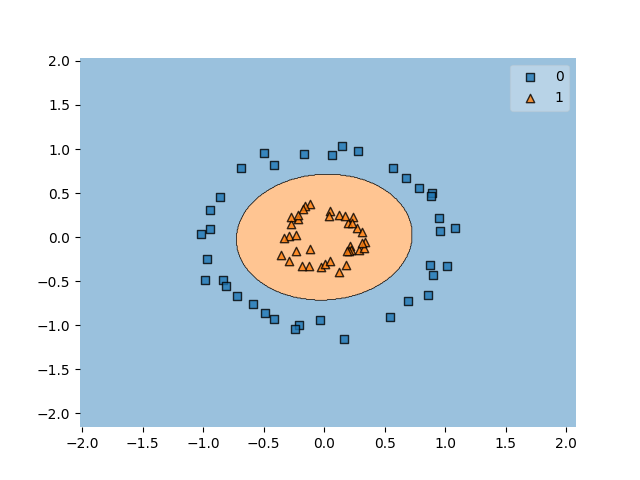

In [ ]:
from sklearn import svm
clf_amu = svm.SVC(kernel="linear", C=5)
clf_amu.fit(X_train, y_train)
fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, clf)
fig.add_subplot(ax)
y_pred1 = clf_amu.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1 )*100
print("accuracy", accuracy1)

accuracy 100.0


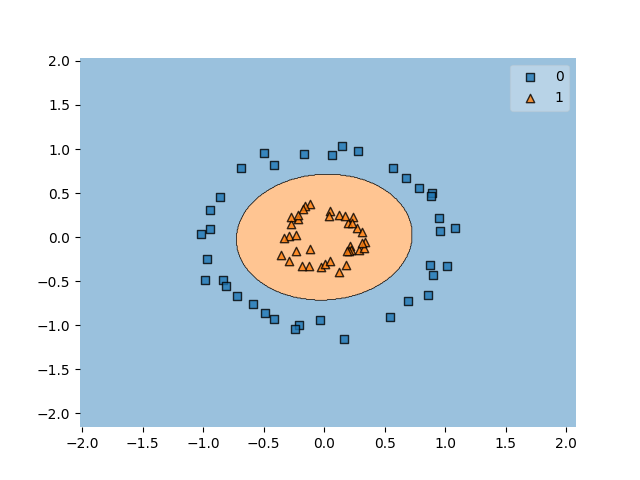

In [ ]:
clf_amu = svm.SVC(kernel="poly",degree = 2)
#fitting the model
clf_amu.fit(X_train, y_train)
#plotting the figure
fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, clf)
fig.add_subplot(ax)
y_pred2 = clf_amu.predict(X_test)
#accuracy after prediction
accuracy1 = accuracy_score(y_test, y_pred2 )*100
print("accuracy", accuracy1)

imported svm from sklearn and i have implemented for both llinear and poly below is the code execution and graphs 

We achieved a perfect accuracy score of 100% using our custom-built polynomial kernel.

Interestingly, when we compare it to the polynomial kernel imported from sklearn, we observe that the custom kernel still maintains a flawless accuracy of 100%. However, the sklearn's linear kernel performs with an accuracy of 68%.